In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from IPython.display import Image


sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.2
ipython_genutils    0.2.0
jedi                0.17.2
jinja2              2.11.3
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.3.0
jupyterlab_server   2.2.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.3
llvmlite            0.35.0
markups

In [3]:

results_file = '../data/pbmc68k.h5ad'  # the file that will store the analysis results
results_T_file = '../data/pbmc68k_Tcells.h5ad'  # the file that will store the analysis results

In [3]:
adata = sc.read_10x_mtx(
    '../data/matrices_mex/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True)                    # write a cache file for faster subsequent reading

In [4]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
adata

AnnData object with n_obs × n_vars = 5898240 × 32738
    var: 'gene_ids'

In [6]:
adata = adata[:,[x for x in adata.var.index if '.' not in x]]

In [7]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=10)

Trying to set attribute `.obs` of view, copying.


In [8]:
adata

AnnData object with n_obs × n_vars = 39180 × 13033
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

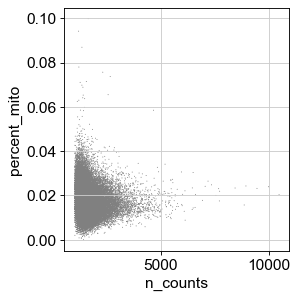

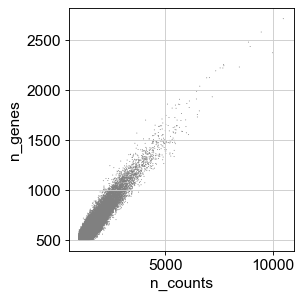

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata

AnnData object with n_obs × n_vars = 39180 × 13033
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'n_cells'

In [12]:
adata.raw = adata

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10, min_disp=0.5)


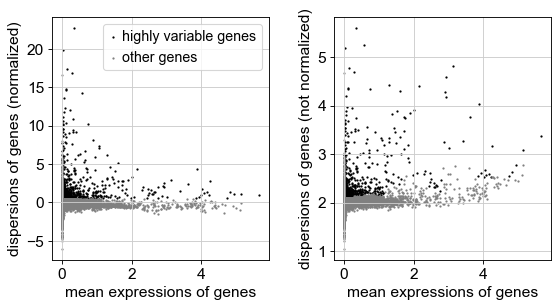

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.var['highly_variable'].value_counts()

False    11744
True      1289
Name: highly_variable, dtype: int64

In [18]:
adata.var.sort_values(by='dispersions_norm', ascending=False).head(10)

gene_ids  n_cells  highly_variable     means  dispersions  \
PPBP   ENSG00000163736      346             True  0.353872     5.606074   
PRSS1  ENSG00000204983       22             True  0.020709     5.176285   
PF4    ENSG00000163737      131             True  0.144130     4.781362   
IGJ    ENSG00000132465      571             True  0.277904     4.695066   
PRSS3  ENSG00000010438       20            False  0.012326     4.663955   
SDPR   ENSG00000168497      182             True  0.105781     4.371452   
GNG11  ENSG00000127920      240             True  0.120869     4.345984   
IGLL5  ENSG00000254709      882             True  0.588009     5.247623   
ACRBP  ENSG00000111644      147             True  0.071134     4.191957   
PTCRA  ENSG00000171611      154             True  0.083949     3.977111   

       dispersions_norm  
PPBP          22.769335  
PRSS1         19.829615  
PF4           17.355515  
IGJ           16.814898  
PRSS3         16.619991  
SDPR          14.787534  
GNG11         14.627980  
IGLL5         14.257865  
ACRBP         13.663036  
PTCRA         12.317080

In [19]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True, zero_center=True)

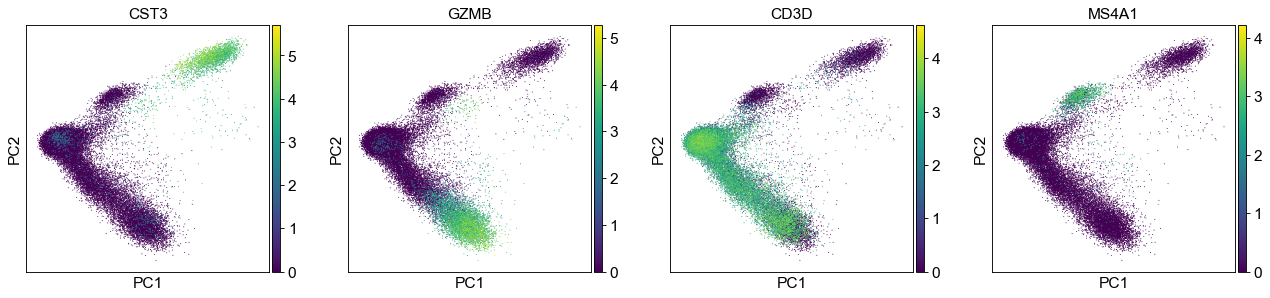

In [21]:
sc.pl.pca(adata, color=['CST3', 'GZMB', 'CD3D', 'MS4A1'], use_raw=False)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


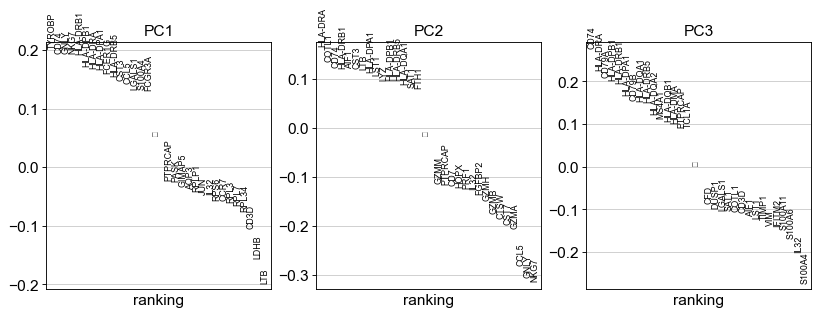

In [22]:
sc.pl.pca_loadings(adata)

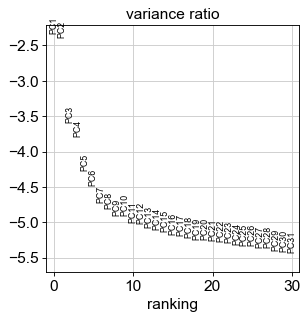

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata

AnnData object with n_obs × n_vars = 39180 × 13033
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=11, random_state=14)

In [26]:
sc.tl.umap(adata, min_dist=.5, spread=1.0, random_state=14)

In [27]:
adata.obs['log10_ncounts'] = adata.obs['n_counts'].apply(np.log10)

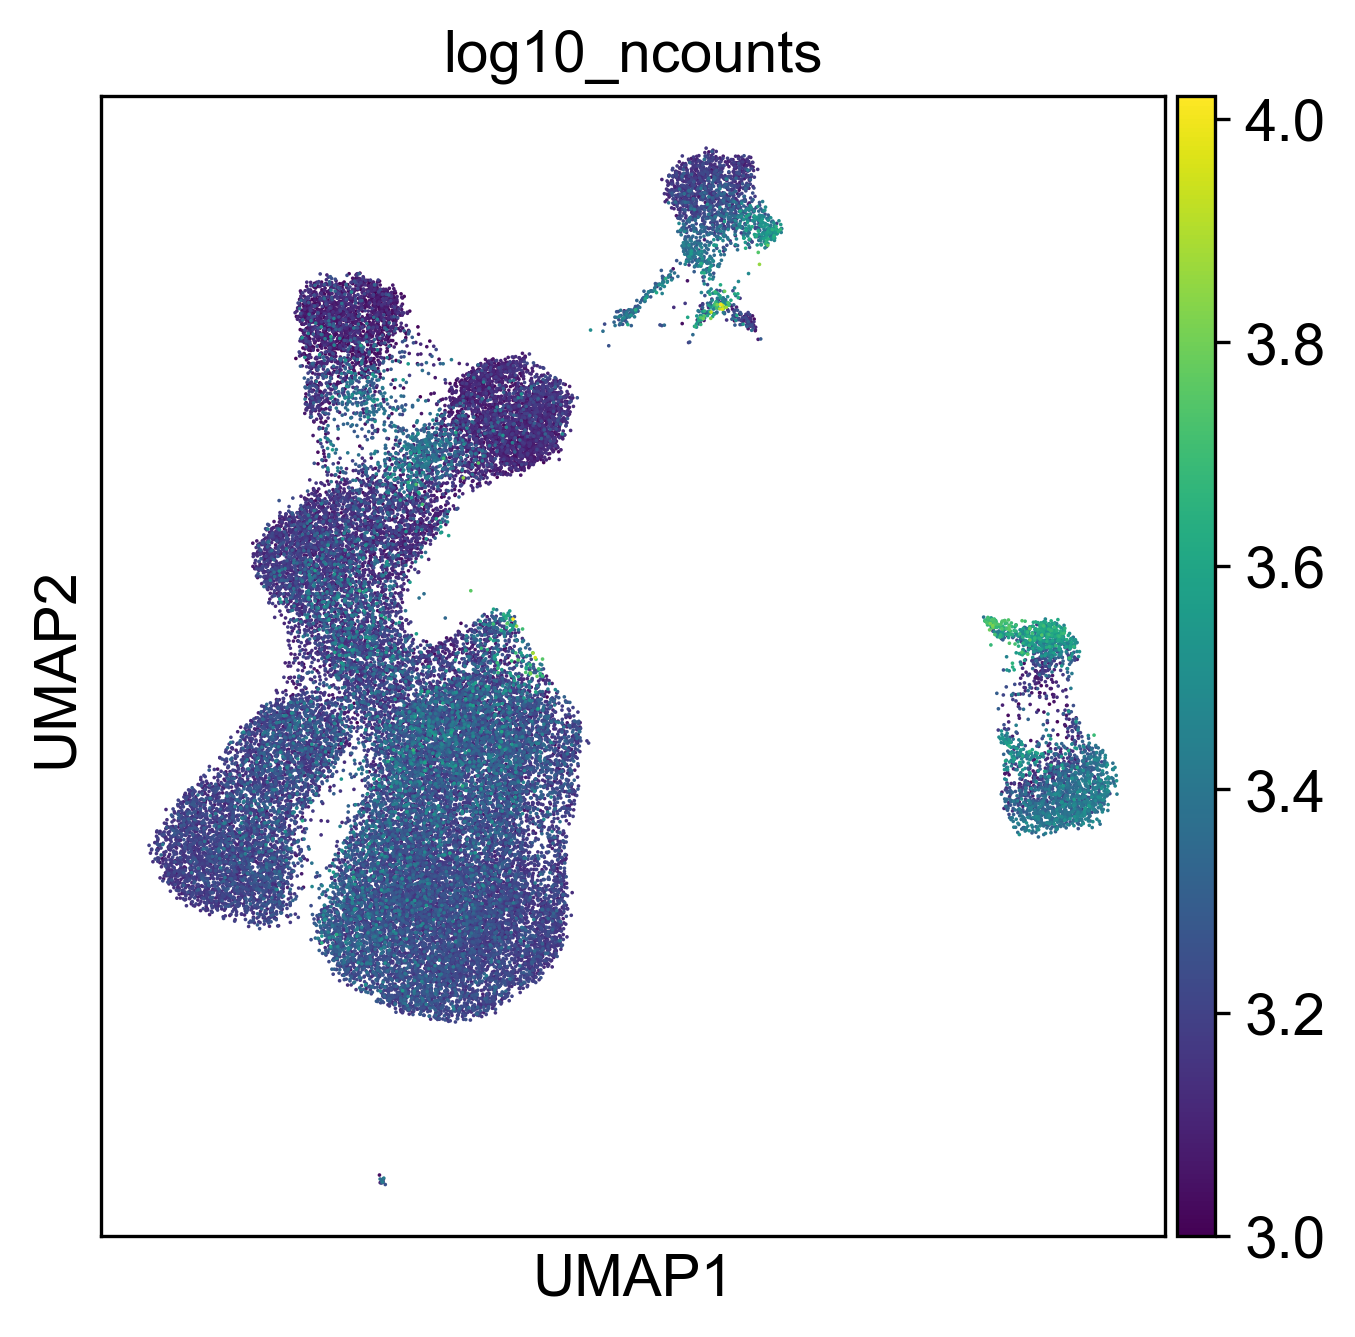

In [28]:
(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=300)
sc.pl.umap(adata, color=['log10_ncounts'], ax=ax, )

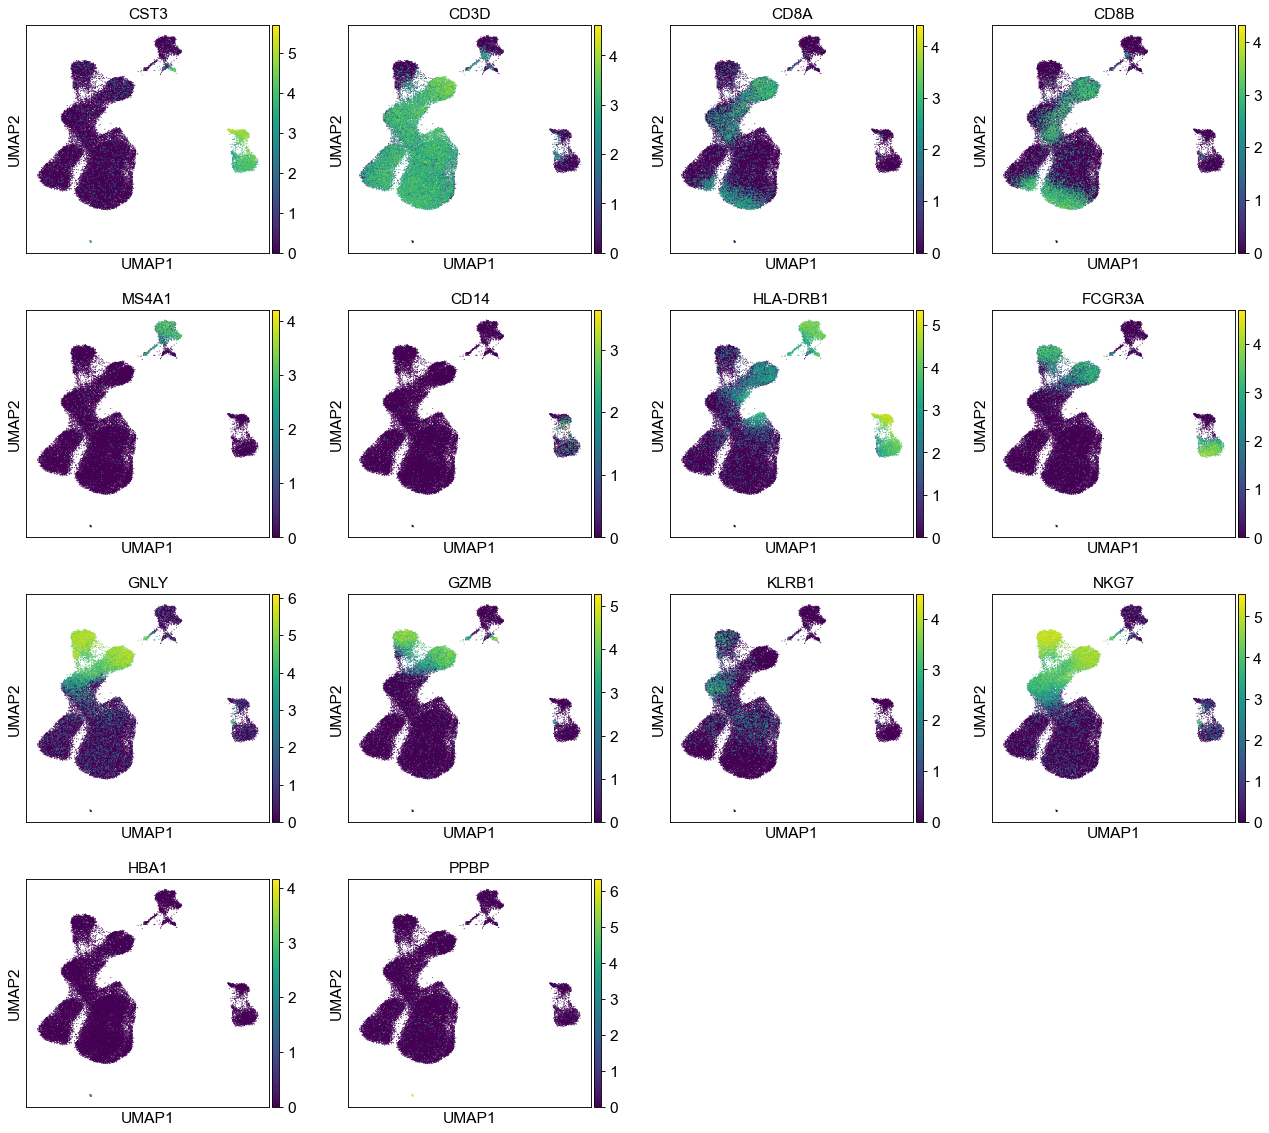

In [26]:
sc.pl.umap(adata, color=['CST3', 'CD3D', 'CD8A', 'CD8B', 'MS4A1', 'CD14', 'HLA-DRB1',
                         'FCGR3A', 'GNLY', 'GZMB',
                           'KLRB1', 'NKG7', 'HBA1', 'PPBP'
                        ], use_raw=False)

In [30]:
sc.tl.leiden(adata, resolution=1., random_state=14)

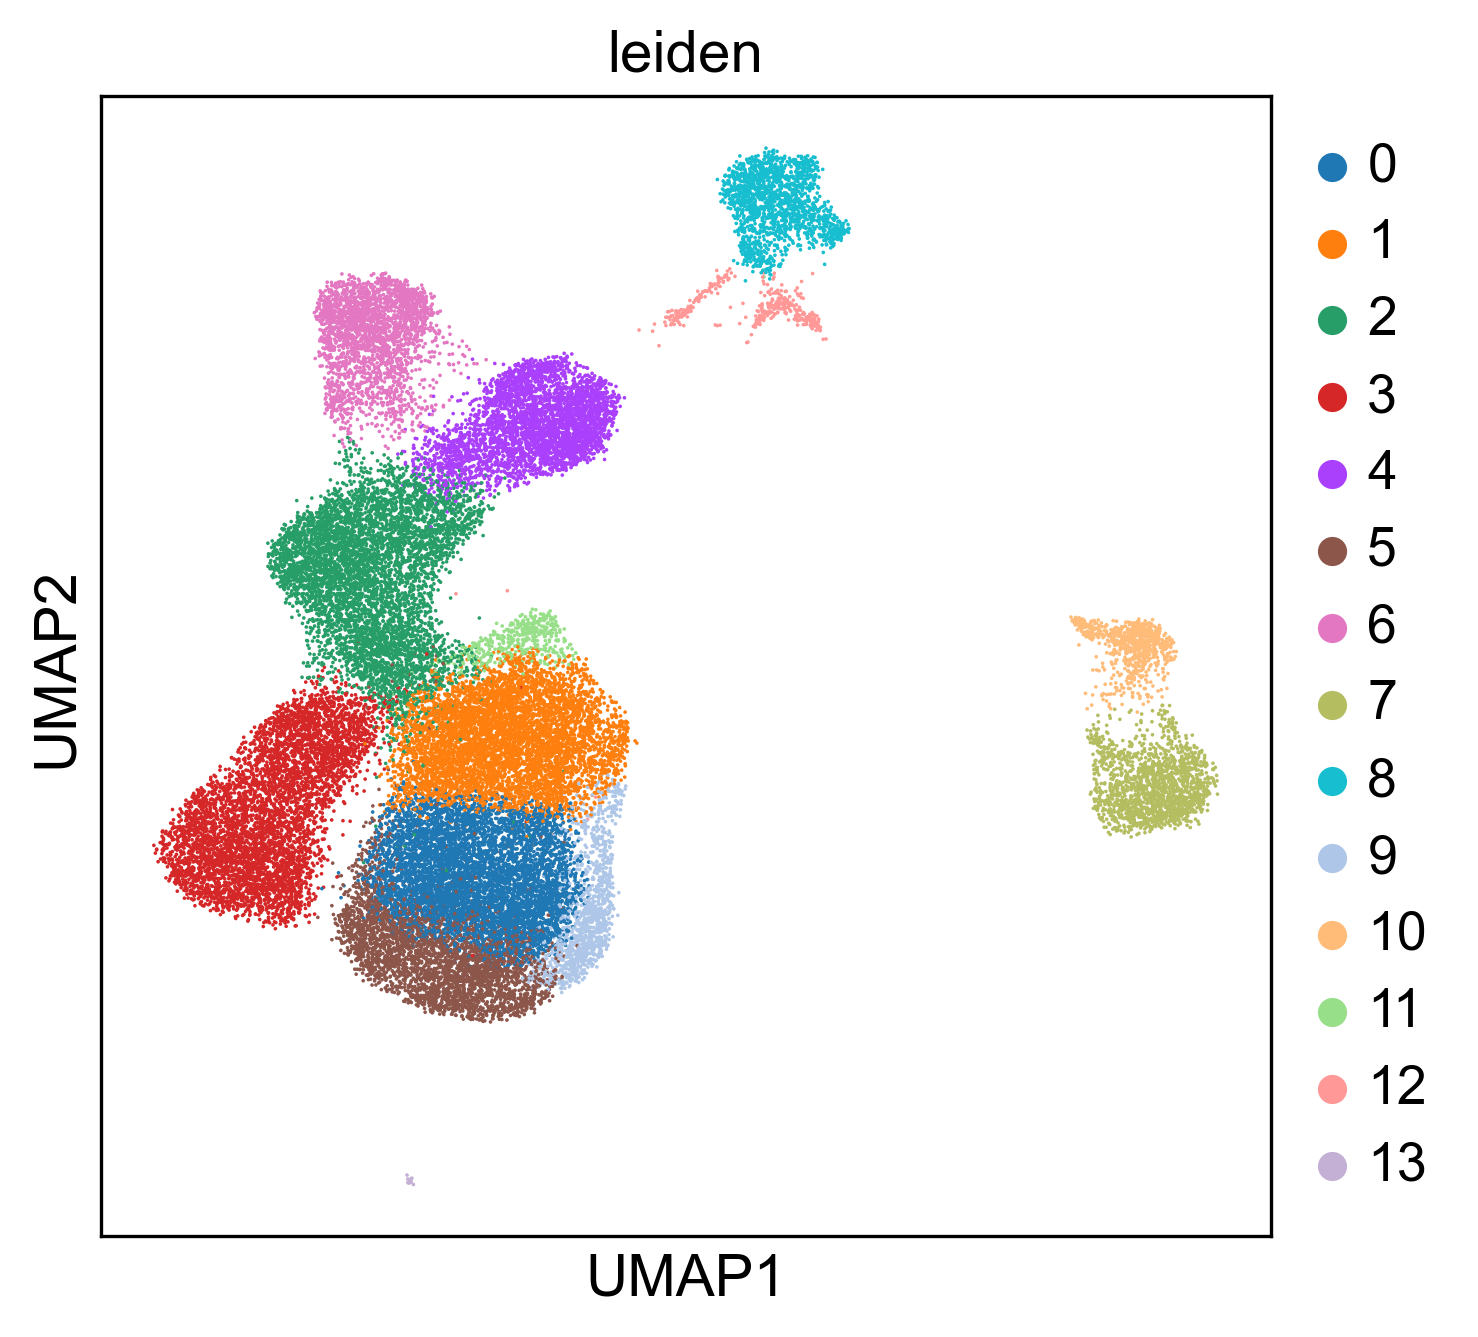

In [31]:
(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=300)
sc.pl.umap(adata, color=['leiden'], ax=ax, )

In [32]:
sc.tl.rank_genes_groups(adata, use_raw=False, groupby='leiden')

In [33]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

0        1       2       3         4       5       6         7  \
0    RPL32   S100A4    CCL5   RPL13      NKG7    CD8B    NKG7      AIF1   
1    RPL13      LTB    GZMK     LTB      CCL5   RPL13    GNLY      LST1   
2    RPS3A     IL32    IL32   RPL11      GNLY   RPS3A  TYROBP    TYROBP   
3    RPL11   MT-ND2    NKG7   RPL32      GZMH   RPL32    CST7       FTL   
4     RPS6      VIM    GZMA    RPS6      GZMB    RPS6    GZMB      FTH1   
5    RPS27     CD52    LYAR    RPS2      CST7  MT-ND2    CTSW    FCER1G   
6   MT-ND2     LDHB   DUSP2  RPL13A       B2M   RPS12    GZMA      CST3   
7    RPL34    FXYD5     B2M   RPS27      GZMA    RPS5  FCER1G      SAT1   
8      LTB     TPT1    CST7   RPS4X     HLA-B    RPS2     CD7     COTL1   
9     RPL9     AQP3   HLA-B    LDHB     HLA-C    RPL3   CLIC3      CD74   
10    RPL3  S100A10    CTSW  RPL18A    FGFBP2   RPL21    PRF1  HLA-DRB1   
11   RPL21    RPL11   DUSP1   RPL10      CTSW   RPS14    PFN1      PSAP   
12    RPL7     RPSA     JUN   RPS25     HLA-A    RPL7  FGFBP2   S100A11   
13   RPS12     IL7R  S100A4   RPS18    S100A4   RPL34    HOPX      CTSS   
14   RPS25    GSTK1   HLA-C    RPL3    TMSB4X  RPL10A     B2M    S100A4   
15   RPS14     PLP2   KLRG1   RPS12  SH3BGRL3   RPS13  IFITM2   HLA-DRA   
16   RPS4X      B2M    HCST   RPL19      CYBA   RPL31   SPON2      OAZ1   
17   RPL31    RPL10    NCR3    TPT1      IL32   RPS25   HLA-A  HLA-DPA1   
18  RPL13A    RPS4X   HLA-A   RPL31    MALAT1   RPS4X    CYBA       CFD   
19   RPS13    RPS18  MT-CO1   RPL18      PRF1    RPL9   PLAC8  SERPINA1   

           8       9        10        11        12      13  
0       CD74   RPL13      CST3    S100A4      CD74    GPX1  
1    HLA-DRA  MT-ND2  HLA-DRB1      IL32  HLA-DRB1    PPBP  
2   HLA-DRB1   RPL32      CD74  HLA-DRB1   HLA-DRA   GNG11  
3   HLA-DPB1   RPS3A   HLA-DRA    TMSB10  HLA-DRB5     PF4  
4      CD79A   RPL11       LYZ      CD52  HLA-DPB1    SDPR  
5   HLA-DPA1    RPL3  HLA-DPB1  SH3BGRL3  HLA-DPA1  TAGLN2  
6      CD79B   RPL34  HLA-DRB5      CD74      GPX1    NRGN  
7   HLA-DRB5   RPS27  HLA-DPA1     HLA-A      CYBA    OAZ1  
8       CD37    RPS6  HLA-DQA1      ACTB  HLA-DQA1    SAT1  
9   HLA-DQA1   RPL21     GSTP1   S100A10      MZB1   TUBB1  
10  HLA-DQA2  RPL13A  HLA-DQB1    S100A6     ITM2C  TUBA4A  
11     MS4A1   RPS25      FTH1    TMSB4X     CD79A   LIMS1  
12       LTB   RPS13  HLA-DQA2      PFN1    SEC61B   SPARC  
13  HLA-DQB1   RPS4X      GPX1  HLA-DRB5   HLA-DMA   RGS10  
14   HLA-DMA  RPL18A      AIF1     ACTG1  HLA-DQB1    CTSA  
15   HLA-DMB     LTB   HLA-DMA      CD3D     GSTP1  FERMT3  
16      LY86   RPL31      LST1    LGALS1     SERF2  MYL12A  
17     RPS11    RPL7      CYBA     GAPDH  HLA-DQA2     GP9  
18      RPS5   RPS12     COTL1     ANXA2       IGJ   PTCRA  
19    RPL18A  RPS27A    TYROBP     COTL1     DERL3   RUFY1

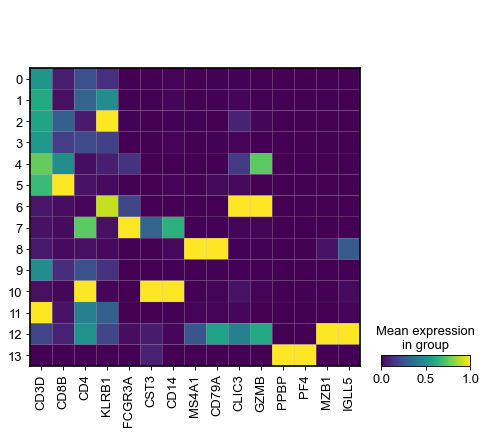

In [34]:
sc.pl.matrixplot(adata, var_names=['CD3D', 'CD8B', 'CD4',
                                   'KLRB1', 'FCGR3A',
                                   'CST3', 'CD14',
                                   'MS4A1', 'CD79A',
                                   'CLIC3', 'GZMB',
                                  'PPBP', 'PF4', 'MZB1', 'IGLL5'],
                 groupby='leiden', standard_scale='var')

In [9]:
clustermap = {'0':'Th 1', '1':'Th 2', '2':'Tc 1', '3':'Th 3',
             '4':'Tc 2', '5':'Tc 3', '6':'NK 1', '7':'Mono_CD16 1',
             '8':'B 1', '9':'Th 4', '10':'Mono_CD14 1', 
             '11':'Th 4', '12':'pDC', '13':'Platelet'}

In [10]:
adata.obs['ClusterFull_1'] = adata.obs['leiden'].replace(clustermap)
adata.obs['Cluster_1'] = adata.obs['ClusterFull_1'].apply(lambda x: x.split(' ')[0])

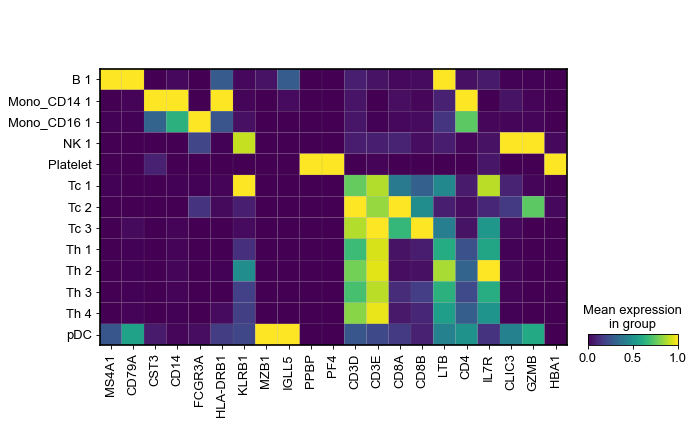

In [25]:
sc.pl.matrixplot(adata, var_names=['MS4A1', 'CD79A',
                                   'CST3', 'CD14', 'FCGR3A', 'HLA-DRB1',
                                   'KLRB1', 
                                    'MZB1', 'IGLL5',
                                   'PPBP', 'PF4',
                                   'CD3D','CD3E', 'CD8A', 'CD8B', 'LTB','CD4', 'IL7R',
                                   
                                   'CLIC3', 'GZMB', 'HBA1',
                                   ],
                 groupby='ClusterFull_1', standard_scale='var')

In [12]:
sc.tl.rank_genes_groups(adata, use_raw=False, groupby='ClusterFull_1')

In [13]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

B 1 Mono_CD14 1 Mono_CD16 1    NK 1 Platelet    Tc 1      Tc 2  \
0       CD74        CST3        AIF1    NKG7     GPX1    CCL5      NKG7   
1    HLA-DRA    HLA-DRB1        LST1    GNLY     PPBP    GZMK      CCL5   
2   HLA-DRB1        CD74      TYROBP  TYROBP    GNG11    IL32      GNLY   
3   HLA-DPB1     HLA-DRA         FTL    CST7      PF4    NKG7      GZMH   
4      CD79A         LYZ        FTH1    GZMB     SDPR    GZMA      GZMB   
5   HLA-DPA1    HLA-DPB1      FCER1G    CTSW   TAGLN2    LYAR      CST7   
6      CD79B    HLA-DRB5        CST3    GZMA     NRGN   DUSP2       B2M   
7   HLA-DRB5    HLA-DPA1        SAT1  FCER1G     OAZ1     B2M      GZMA   
8       CD37    HLA-DQA1       COTL1     CD7     SAT1    CST7     HLA-B   
9   HLA-DQA1       GSTP1        CD74   CLIC3    TUBB1   HLA-B     HLA-C   
10  HLA-DQA2    HLA-DQB1    HLA-DRB1    PRF1   TUBA4A    CTSW    FGFBP2   
11     MS4A1        FTH1        PSAP    PFN1    LIMS1   DUSP1      CTSW   
12       LTB    HLA-DQA2     S100A11  FGFBP2    SPARC     JUN     HLA-A   
13  HLA-DQB1        GPX1        CTSS    HOPX    RGS10  S100A4    S100A4   
14   HLA-DMA        AIF1      S100A4     B2M     CTSA   HLA-C    TMSB4X   
15   HLA-DMB     HLA-DMA     HLA-DRA  IFITM2   FERMT3   KLRG1  SH3BGRL3   
16      LY86        LST1        OAZ1   SPON2   MYL12A    HCST      CYBA   
17     RPS11        CYBA    HLA-DPA1   HLA-A      GP9    NCR3      IL32   
18      RPS5       COTL1         CFD    CYBA    PTCRA   HLA-A    MALAT1   
19    RPL18A      TYROBP    SERPINA1   PLAC8    RUFY1  MT-CO1      PRF1   

      Tc 3    Th 1     Th 2    Th 3      Th 4       pDC  
0     CD8B   RPL32   S100A4   RPL13      LDHB      CD74  
1    RPL13   RPL13      LTB     LTB    TMSB10  HLA-DRB1  
2    RPS3A   RPS3A     IL32   RPL11       LTB   HLA-DRA  
3    RPL32   RPL11   MT-ND2   RPL32      CD3E  HLA-DRB5  
4     RPS6    RPS6      VIM    RPS6       AES  HLA-DPB1  
5   MT-ND2   RPS27     CD52    RPS2      CD27  HLA-DPA1  
6    RPS12  MT-ND2     LDHB  RPL13A     CCR10      GPX1  
7     RPS5   RPL34    FXYD5   RPS27      CD3D      CYBA  
8     RPS2     LTB     TPT1   RPS4X    TMEM66  HLA-DQA1  
9     RPL3    RPL9     AQP3    LDHB      NPM1      MZB1  
10   RPL21    RPL3  S100A10  RPL18A    RPS15A     ITM2C  
11   RPS14   RPL21    RPL11   RPL10     NOSIP     CD79A  
12    RPL7    RPL7     RPSA   RPS25  TRAF3IP3    SEC61B  
13   RPL34   RPS12     IL7R   RPS18      CD52   HLA-DMA  
14  RPL10A   RPS25    GSTK1    RPL3    GNB2L1  HLA-DQB1  
15   RPS13   RPS14     PLP2   RPS12       LAT     GSTP1  
16   RPL31   RPS4X      B2M   RPL19     RPL11     SERF2  
17   RPS25   RPL31    RPL10    TPT1      AQP3  HLA-DQA2  
18   RPS4X  RPL13A    RPS4X   RPL31   ARHGDIB       IGJ  
19    RPL9   RPS13    RPS18   RPL18     RPL34     DERL3

In [14]:
adata.write(results_file)

In [24]:
adata = sc.read(results_file)

In [17]:
adata.obs['Cluster_1'].value_counts()

Th           19166
Tc           13002
NK            2523
Mono_CD16     1647
B             1639
Mono_CD14      789
pDC            392
Platelet        22
Name: Cluster_1, dtype: int64

In [18]:
pd.crosstab(adata.obs['Cluster_1'], adata.obs['ClusterFull_1'])

ClusterFull_1   B 1  Mono_CD14 1  Mono_CD16 1  NK 1  Platelet  Tc 1  Tc 2  \
Cluster_1                                                                   
B              1639            0            0     0         0     0     0   
Mono_CD14         0          789            0     0         0     0     0   
Mono_CD16         0            0         1647     0         0     0     0   
NK                0            0            0  2523         0     0     0   
Platelet          0            0            0     0        22     0     0   
Tc                0            0            0     0         0  5790  3734   
Th                0            0            0     0         0     0     0   
pDC               0            0            0     0         0     0     0   

ClusterFull_1  Tc 3  Th 1  Th 2  Th 3  Th 4  pDC  
Cluster_1                                         
B                 0     0     0     0     0    0  
Mono_CD14         0     0     0     0     0    0  
Mono_CD16         0     0     0     0     0    0  
NK                0     0     0     0     0    0  
Platelet          0     0     0     0     0    0  
Tc             3478     0     0     0     0    0  
Th                0  6118  6042  5373  1633    0  
pDC               0     0     0     0     0  392

In [29]:
adata_T = sc.AnnData(adata.raw.X.copy(), obs=adata.obs.copy(), var= adata.raw.var.copy())

In [30]:
adata_T

AnnData object with n_obs × n_vars = 39180 × 13033
    obs: 'n_genes', 'n_counts', 'percent_mito', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'

In [31]:
adata_T.obs['Cluster_1'].isin(['Th', 'Tc']).value_counts()

True     32168
False     7012
Name: Cluster_1, dtype: int64

In [32]:
adata_T = adata_T[adata_T.obs['Cluster_1'].isin(['Th', 'Tc']).values, :]
adata_T

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 32168 × 13033
    obs: 'n_genes', 'n_counts', 'percent_mito', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'

In [33]:
adata_T.raw = adata_T

In [34]:
sc.pp.filter_genes(adata_T, min_cells=10)

In [35]:
sc.pp.normalize_per_cell(adata_T, counts_per_cell_after=1e4)

In [36]:
adata_T

AnnData object with n_obs × n_vars = 32168 × 12244
    obs: 'n_genes', 'n_counts', 'percent_mito', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'

In [37]:
sc.pp.log1p(adata_T)

In [38]:
adata_T

AnnData object with n_obs × n_vars = 32168 × 12244
    obs: 'n_genes', 'n_counts', 'percent_mito', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'

In [39]:
sc.pp.highly_variable_genes(adata_T, min_mean=0.0125, max_mean=10, min_disp=0.5)


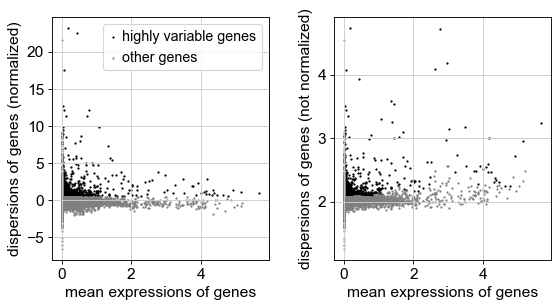

In [40]:
sc.pl.highly_variable_genes(adata_T)

In [41]:
adata_T.var['highly_variable'].value_counts()

False    10567
True      1677
Name: highly_variable, dtype: int64

In [42]:
adata_T.var.sort_values(by='dispersions_norm', ascending=False).head(10)

gene_ids  n_cells  highly_variable     means  dispersions  \
PPBP    ENSG00000163736      251             True  0.180279     4.740271   
PTGDS   ENSG00000107317      782             True  0.424396     3.926019   
PRSS1   ENSG00000204983       10            False  0.005738     4.552502   
PF4     ENSG00000163737       82             True  0.063917     4.074995   
GNG11   ENSG00000127920       87             True  0.043396     3.506734   
SDPR    ENSG00000168497      118             True  0.050665     3.450741   
TYROBP  ENSG00000011600     2554             True  0.769603     3.052919   
S100B   ENSG00000160307     2475             True  0.715550     2.985739   
S100A8  ENSG00000143546      362             True  0.106612     3.344869   
FGFBP2  ENSG00000137441     3292             True  1.067349     3.301776   

        dispersions_norm  
PPBP           23.250441  
PTGDS          22.493952  
PRSS1          21.644056  
PF4            17.558933  
GNG11          12.697401  
SDPR           12.218377  
TYROBP         12.175864  
S100B          11.369148  
S100A8         11.312633  
FGFBP2          9.904891

In [43]:
sc.tl.pca(adata_T, svd_solver='arpack', random_state=14, zero_center=True, use_highly_variable=True)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


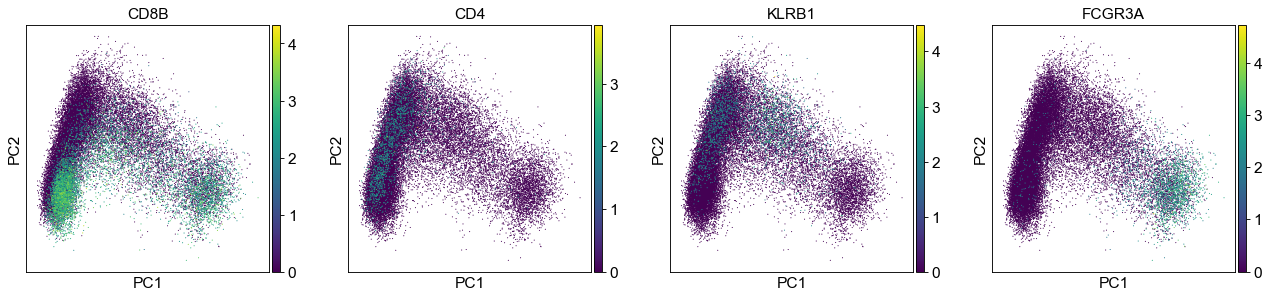

In [44]:
sc.pl.pca(adata_T, color=['CD8B', 'CD4', 'KLRB1', 'FCGR3A'], use_raw=False)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


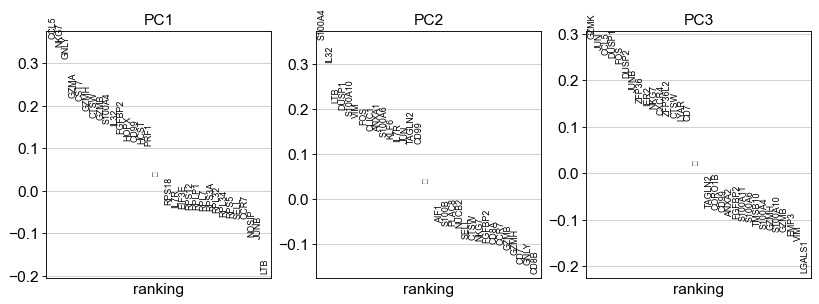

In [45]:
sc.pl.pca_loadings(adata_T)

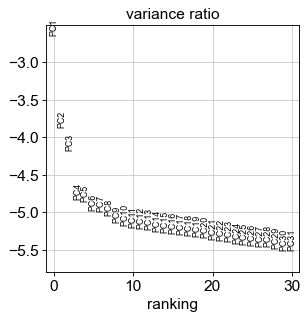

In [46]:
sc.pl.pca_variance_ratio(adata_T, log=True)

In [47]:
adata_T

AnnData object with n_obs × n_vars = 32168 × 12244
    obs: 'n_genes', 'n_counts', 'percent_mito', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [18]:
sc.pp.neighbors(adata_T, n_neighbors=50, n_pcs=9, random_state=14)

In [21]:
sc.tl.umap(adata_T, min_dist=.5, spread=2.0, random_state=14)

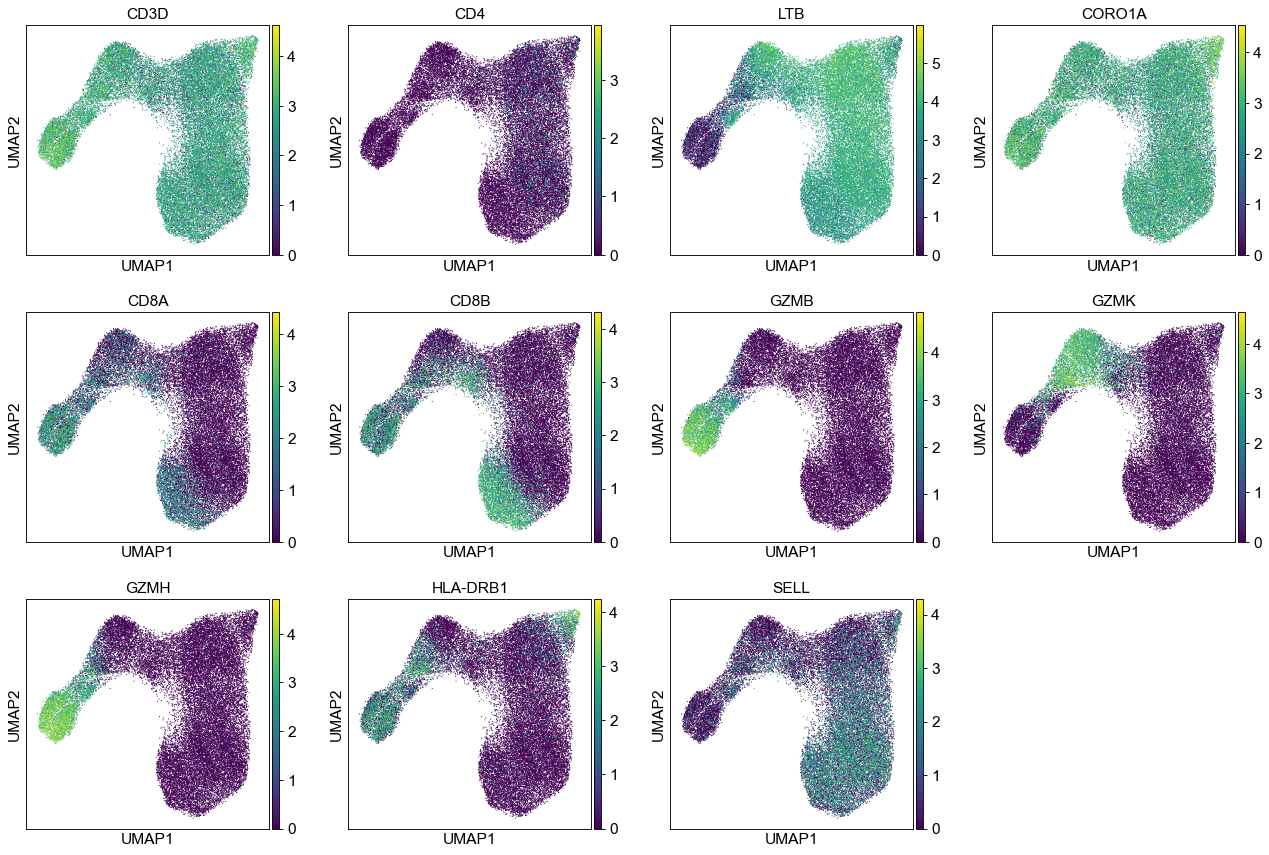

In [49]:
sc.pl.umap(adata_T, color=['CD3D', 'CD4', 'LTB', 'CORO1A', 'CD8A', 'CD8B', 'GZMB', 'GZMK','GZMH', 'HLA-DRB1', 'SELL'], use_raw=False)

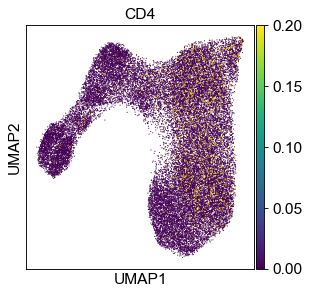

In [27]:
sc.pl.umap(adata_T, color=['CD4'], use_raw=False, vmax=.2)

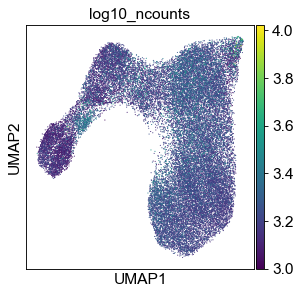

In [28]:
sc.pl.umap(adata_T, color=['log10_ncounts'])

In [29]:
sc.tl.leiden(adata_T, resolution=2.0, random_state=14)

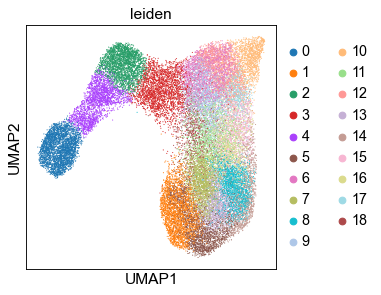

In [30]:
sc.pl.umap(adata_T, color=['leiden'])

In [31]:
adata_T.obs['leiden'].value_counts()

0     3034
1     2596
2     2471
3     2360
4     2152
5     2081
6     2043
7     1920
8     1893
9     1511
10    1412
11    1317
12    1311
13    1301
14    1148
15    1091
16    1072
17     767
18     688
Name: leiden, dtype: int64

In [32]:
sc.tl.rank_genes_groups(adata_T, use_raw=False, groupby='leiden')

In [33]:
pd.DataFrame(adata_T.uns['rank_genes_groups']['names']).head(50)

0        1        2         3         4       5         6        7  \
0       NKG7  MT-ATP6     CCL5      CCL5      CCL5   RPL13    S100A4  MT-ATP6   
1       GNLY     CD8B     GZMK      IL32      NKG7    CD8B   MT-ATP6    RPL34   
2       CCL5    RPS3A     NKG7      LYAR      CST7   RPL32       LTB    RPS3A   
3       GZMH     RPL7     GZMA      IL7R      GZMA    RPS5      IL32     RPL7   
4       GZMB    RPL34    DUSP1    S100A4      GZMK    RPS2       VIM    RPL21   
5        B2M   MT-CO2     IL32       FOS      GNLY    RPS6   S100A10    RPL32   
6       CST7    RPL13   S100A4     DUSP1     HLA-B   RPS13     ANXA1    RPL11   
7       GZMA    RPL21     CST7       LTB      CTSW   RPS14     RPL34     RPL9   
8      HLA-B     RPS6    DUSP2      GZMK       B2M   RPL31      IL7R     JUNB   
9      HLA-C    RPL32     CTSW       JUN     HLA-C   RPL19     FXYD5    RPL13   
10    FGFBP2     RPS5      FOS     RPS19     HLA-A   RPS12    MT-CO2   RPS27A   
11      CTSW    RPS13    HLA-B      KLF6      CD74  RPL10A     TIMP1    RPS13   
12     HLA-A    RPS12     NCR3    PTGER2      CYBA     CD7   S100A11     RPS6   
13      CYBA     RPS2   MT-CO1     CXCR3  HLA-DRB1    RPL3    LGALS1    RPS14   
14    TMSB4X   RPL10A     LYAR    RPL13A      HCST    RPS9    TAGLN2    RPL31   
15    S100A4    RPS14    CEBPD   S100A10  HLA-DPB1    RPS8     TRADD    RPS25   
16  SH3BGRL3     RPL9      JUN   ZFP36L2      GZMH    RPL5      RPL7    RPS27   
17      PRF1     RPL3    HLA-C      RPL3      PFN1   RPS19      PLP2     RPS5   
18    MALAT1    RPL31   MT-CO3     ZFP36      IL32   RPL11       FOS    RPLP2   
19    LGALS1    RPS25    KLRG1     RPLP0      LYAR   RPL10    RPS27A    RPL30   
20    FCGR3A    S100B   NFKBIA     CXCR4      CD99   RPLP2  SH3BGRL3    RPS23   
21      HOPX    RPS23      ID2      JUNB      GZMM   RPL12      FTH1     LDHB   
22      CD99     RPS9    KLRB1    MT-ND1  SH3BGRL3  RPL18A      KLF6   RPS15A   
23      PFN1      CD7     HCST    MT-ND4      HOPX   RPS25   TNFRSF4     RPS8   
24      HCST    RPS19    ZFP36     ANXA1     DUSP2   RPL18     GSTK1   RPL35A   
25      CD8A     RPL4      B2M     HLA-B  HLA-DRB5  EEF1B2       B2M   RPL13A   
26  HLA-DPB1    RPL11     HOPX     DUSP2   PTPRCAP   RPS23      RPSA     RPS2   
27      CD63     RPS8   MT-ND1      HOPX  HLA-DPA1   S100B      AQP3     IER2   
28      SRGN   RPL18A   MT-ND4      RPSA    MT-CO1  RPL13A    S100A6      LTB   
29  HLA-DRB1    RPL19    CXCR4      RPS3     CLIC1    CCR7      TPT1   MT-CO2   
30      CCL4     RPL5     IL7R    MT-CO1      CCL4   RPS15      CD52     RPL3   
31    TYROBP   EEF1B2    CLIC1    MT-ND2      SRGN    RPL4     ANXA2     RPL4   
32      IL32    RPL18  ZFP36L2     TRADD     KLRG1    NPM1     DUSP1    RPL19   
33  HLA-DRB5    RPS4X     MATK  PPP1R15A      MATK   RPS4X     COTL1   RPL10A   
34  C12orf75    RPL12   MT-CO2       B2M  C12orf75  RPL35A    MT-ND2     SELL   
35   PTPRCAP    RPLP2    HLA-A    NFKBIA      PRF1   RPS3A    IFITM2   RPL18A   
36    ZNF683   RPS27A   MT-CYB     COTL1    S100A4   RPS16    EEF1A1    EIF3E   
37     CLIC1    RPL15     CYBA      CD8B  APOBEC3G   RPL28     RPLP0    RPS12   
38    PRSS23    RGS10   MT-ND2      NSG1    FGFBP2   RPL15      EMP3    RPS4X   
39     SPON2     NPM1  ALOX5AP     TIMP1      GZMB   RPL14      CAPG     RPS9   
40      LSP1     CCR7   FKBP11      RPL8     CLIC3   RGS10     GAPDH    RPS18   
41  HLA-DPA1   MT-ND2    ARL4C      RPS2    TMSB4X    CD8A     USP10    RPL18   
42  APOBEC3G   MT-ND4     LST1     CLIC3      PLEK   RPS18      RPL8     RPL5   
43     ASCL2     CD8A    RPLP0       ID2      CD8A   RPL29     CRIP1     CCR7   
44     ITGB2     LDHB     GZMM  ARHGAP15      CD63   RPS28      CTSH     NPM1   
45      PLEK    RPS15   CITED2   FAM173A    TYROBP   NOSIP     CLIC1    RPS16   
46    IFITM2     CARS   PMAIP1       FTL     APMAP    CD27     NOSIP    RPL36   
47     KLRD1    RPL10   AMICA1     RPL13       UBB   RPS27      LDHA    RPS20   
48    S100A6    RPS28    H3F3B      CTSW  

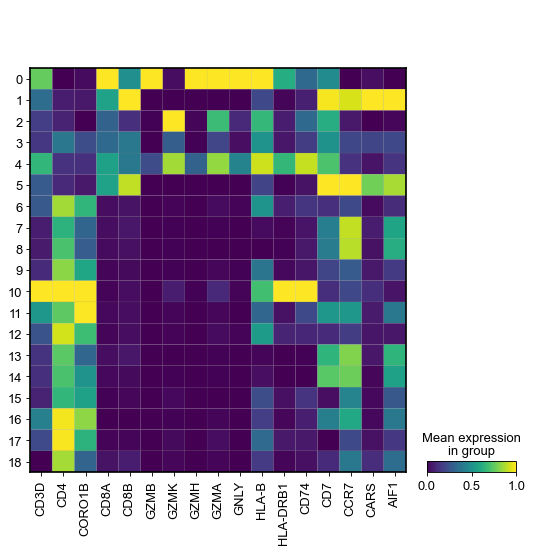

In [40]:
sc.pl.matrixplot(adata_T, var_names=['CD3D', 'CD4','CORO1B', 'CD8A', 'CD8B', 'GZMB', 'GZMK', 'GZMH', 'GZMA', 'GNLY', 'HLA-B', 'HLA-DRB1', 'CD74', 
                                     'CD7', 'CCR7', 'CARS', 'AIF1'],
                 groupby='leiden', standard_scale='var')

In [69]:
X = pd.DataFrame(adata_T.X.todense(), index=adata_T.obs.index, columns=adata_T.var.index)

In [73]:
R = X.corrwith(X['CD4'])

In [74]:
R = R.sort_values(ascending=False)

In [75]:
R.head(10)

CD4        1.000000
LTB        0.079636
LDHB       0.061066
CORO1B     0.059052
TMSB10     0.052984
RPL11      0.047377
FTH1       0.045569
MAL        0.045495
AQP3       0.040646
RNASET2    0.039655
dtype: float64

In [76]:
R.tail(10)

GZMB   -0.066530
GZMH   -0.070042
GNLY   -0.077739
GZMA   -0.078568
CD8A   -0.084936
CST7   -0.085242
CD8B   -0.099566
CCL5   -0.103026
CTSW   -0.103904
NKG7   -0.105822
dtype: float64

In [96]:
adata_T.write(results_T_file)


In [4]:
adata_T = sc.read(results_T_file)


In [5]:
adata_T

AnnData object with n_obs × n_vars = 32168 × 12244
    obs: 'n_genes', 'n_counts', 'percent_mito', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Run cNMF

In [6]:
import numpy as np

In [ ]:
adata_T_raw = sc.AnnData(adata_T.raw.X.copy(), obs=adata_T.obs.copy(), var= adata_T.raw.var.copy())
sc.pp.filter_genes(adata_T_raw, min_cells=10)

In [ ]:
sc.write('../data/pbmc68k_Tcells_rawForcNMF.h5ad', adata_T_raw)

In [6]:

odir = '../data/cNMF'
name = 'pbmc68k_T'
infn = '../data/pbmc68k_Tcells_rawForcNMF.h5ad'
niter = 50
ks = ' '.join([str(x) for x in np.arange(3,10)])

In [ ]:
cmd = 'python ../../cNMF/cnmf.py prepare --output-dir {o} --name {name} -c {inv} -k {K} --n-iter {n} --total-workers 1 --seed 14 --numgenes 2000'.format(o=odir, name=name, n=niter, K=ks, inv=infn)
print(cmd)
!{cmd}

In [14]:
cmd = 'python ../../cNMF/cnmf.py factorize --output-dir {o} --name {name}'.format(o=odir, name=name)
print(cmd)
!{cmd}

python ../../cNMF/cnmf.py factorize --output-dir ../data/cNMF --name pbmc68k_T
[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[

In [16]:
cmd = 'python ../../cNMF/cnmf.py combine --output-dir {o} --name {name}'.format(o=odir, name=name)
print(cmd)
!{cmd}

python ../../cNMF/cnmf.py combine --output-dir ../data/cNMF --name pbmc68k_T
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.


In [17]:
cmd = 'python ../../cNMF/cnmf.py k_selection_plot --output-dir {o} --name {name}'.format(o=odir, name=name)
print(cmd)
!{cmd}

python ../../cNMF/cnmf.py k_selection_plot --output-dir ../data/cNMF --name pbmc68k_T


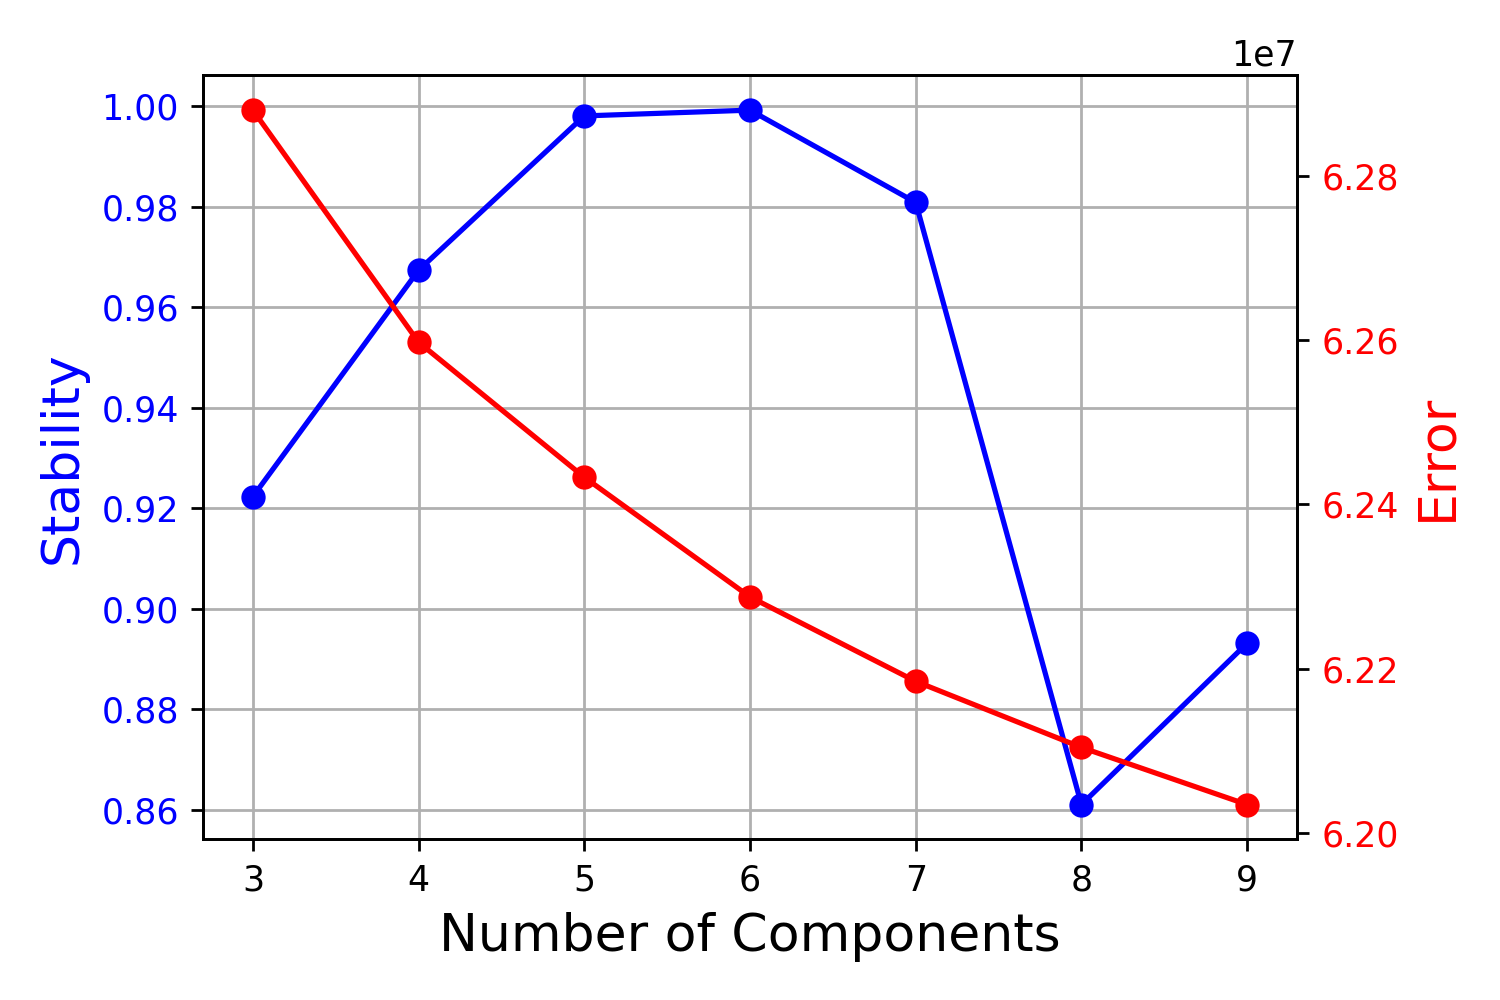

In [23]:

Image('../data/cNMF/pbmc68k_T/pbmc68k_T.k_selection.png')

In [50]:
selected_K = 9
density_threshold = 2.00

In [51]:
consensus_cmd = 'python ../../cNMF/cnmf.py consensus --output-dir {o} --name {name} --local-density-threshold {dens} --components {K} --show-clustering'.format(o=odir, name=name, dens=density_threshold, K=selected_K)
print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}


Consensus command for K=9:
python ../../cNMF/cnmf.py consensus --output-dir ../data/cNMF --name pbmc68k_T --local-density-threshold 2.0 --components 9 --show-clustering
Traceback (most recent call last):
  File "../../cNMF/cnmf.py", line 7, in <module>
    import yaml
ModuleNotFoundError: No module named 'yaml'


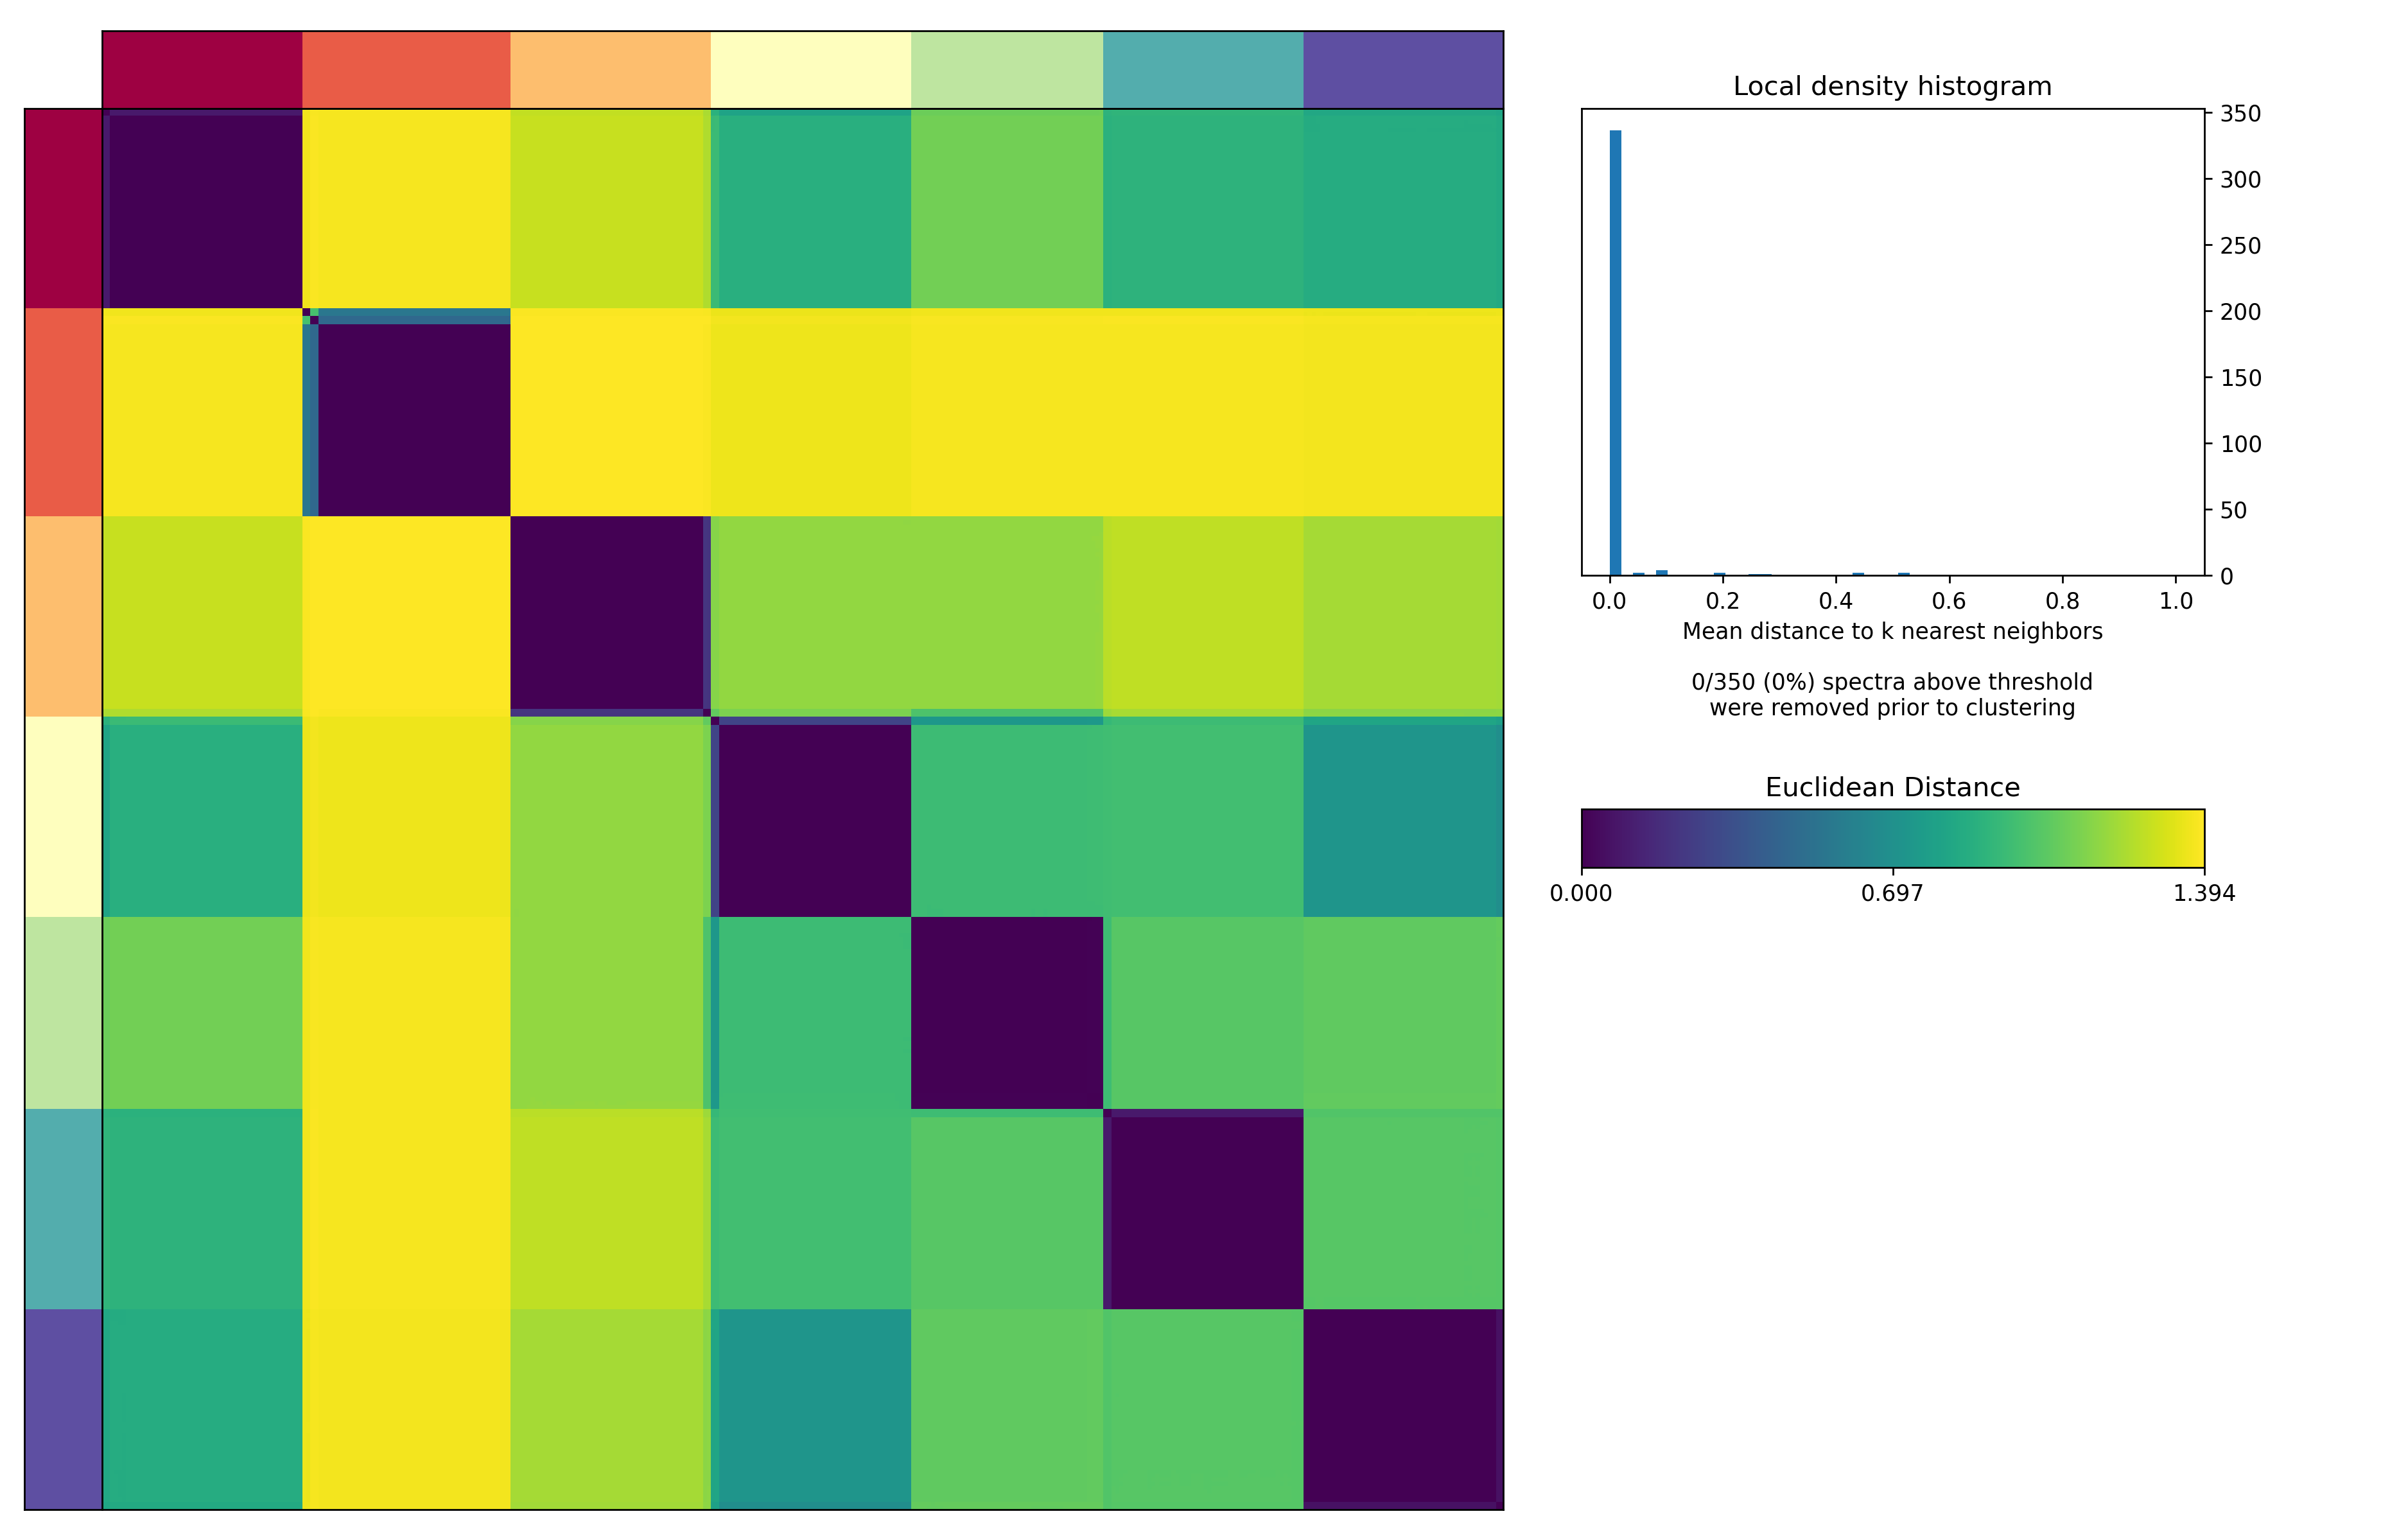

In [30]:
density_threshold_str = ('%.1f' % density_threshold).replace('.', '_')
fn = "{o}/{name}/{name}.clustering.k_{K}.dt_{ds}.png".format(o=odir, name=name, K=selected_K, ds=density_threshold_str)
Image(filename = fn,
      width=1000, height=1000)

In [7]:
selected_K = 7
density_threshold = 0.05

In [32]:
consensus_cmd = 'python ../../cNMF/cnmf.py consensus --output-dir {o} --name {name} --local-density-threshold {dens} --components {K} --show-clustering'.format(o=odir, name=name, dens=density_threshold, K=selected_K)
print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=7:
python ../../cNMF/cnmf.py consensus --output-dir ../data/cNMF --name pbmc68k_T --local-density-threshold 0.05 --components 7 --show-clustering


In [9]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')


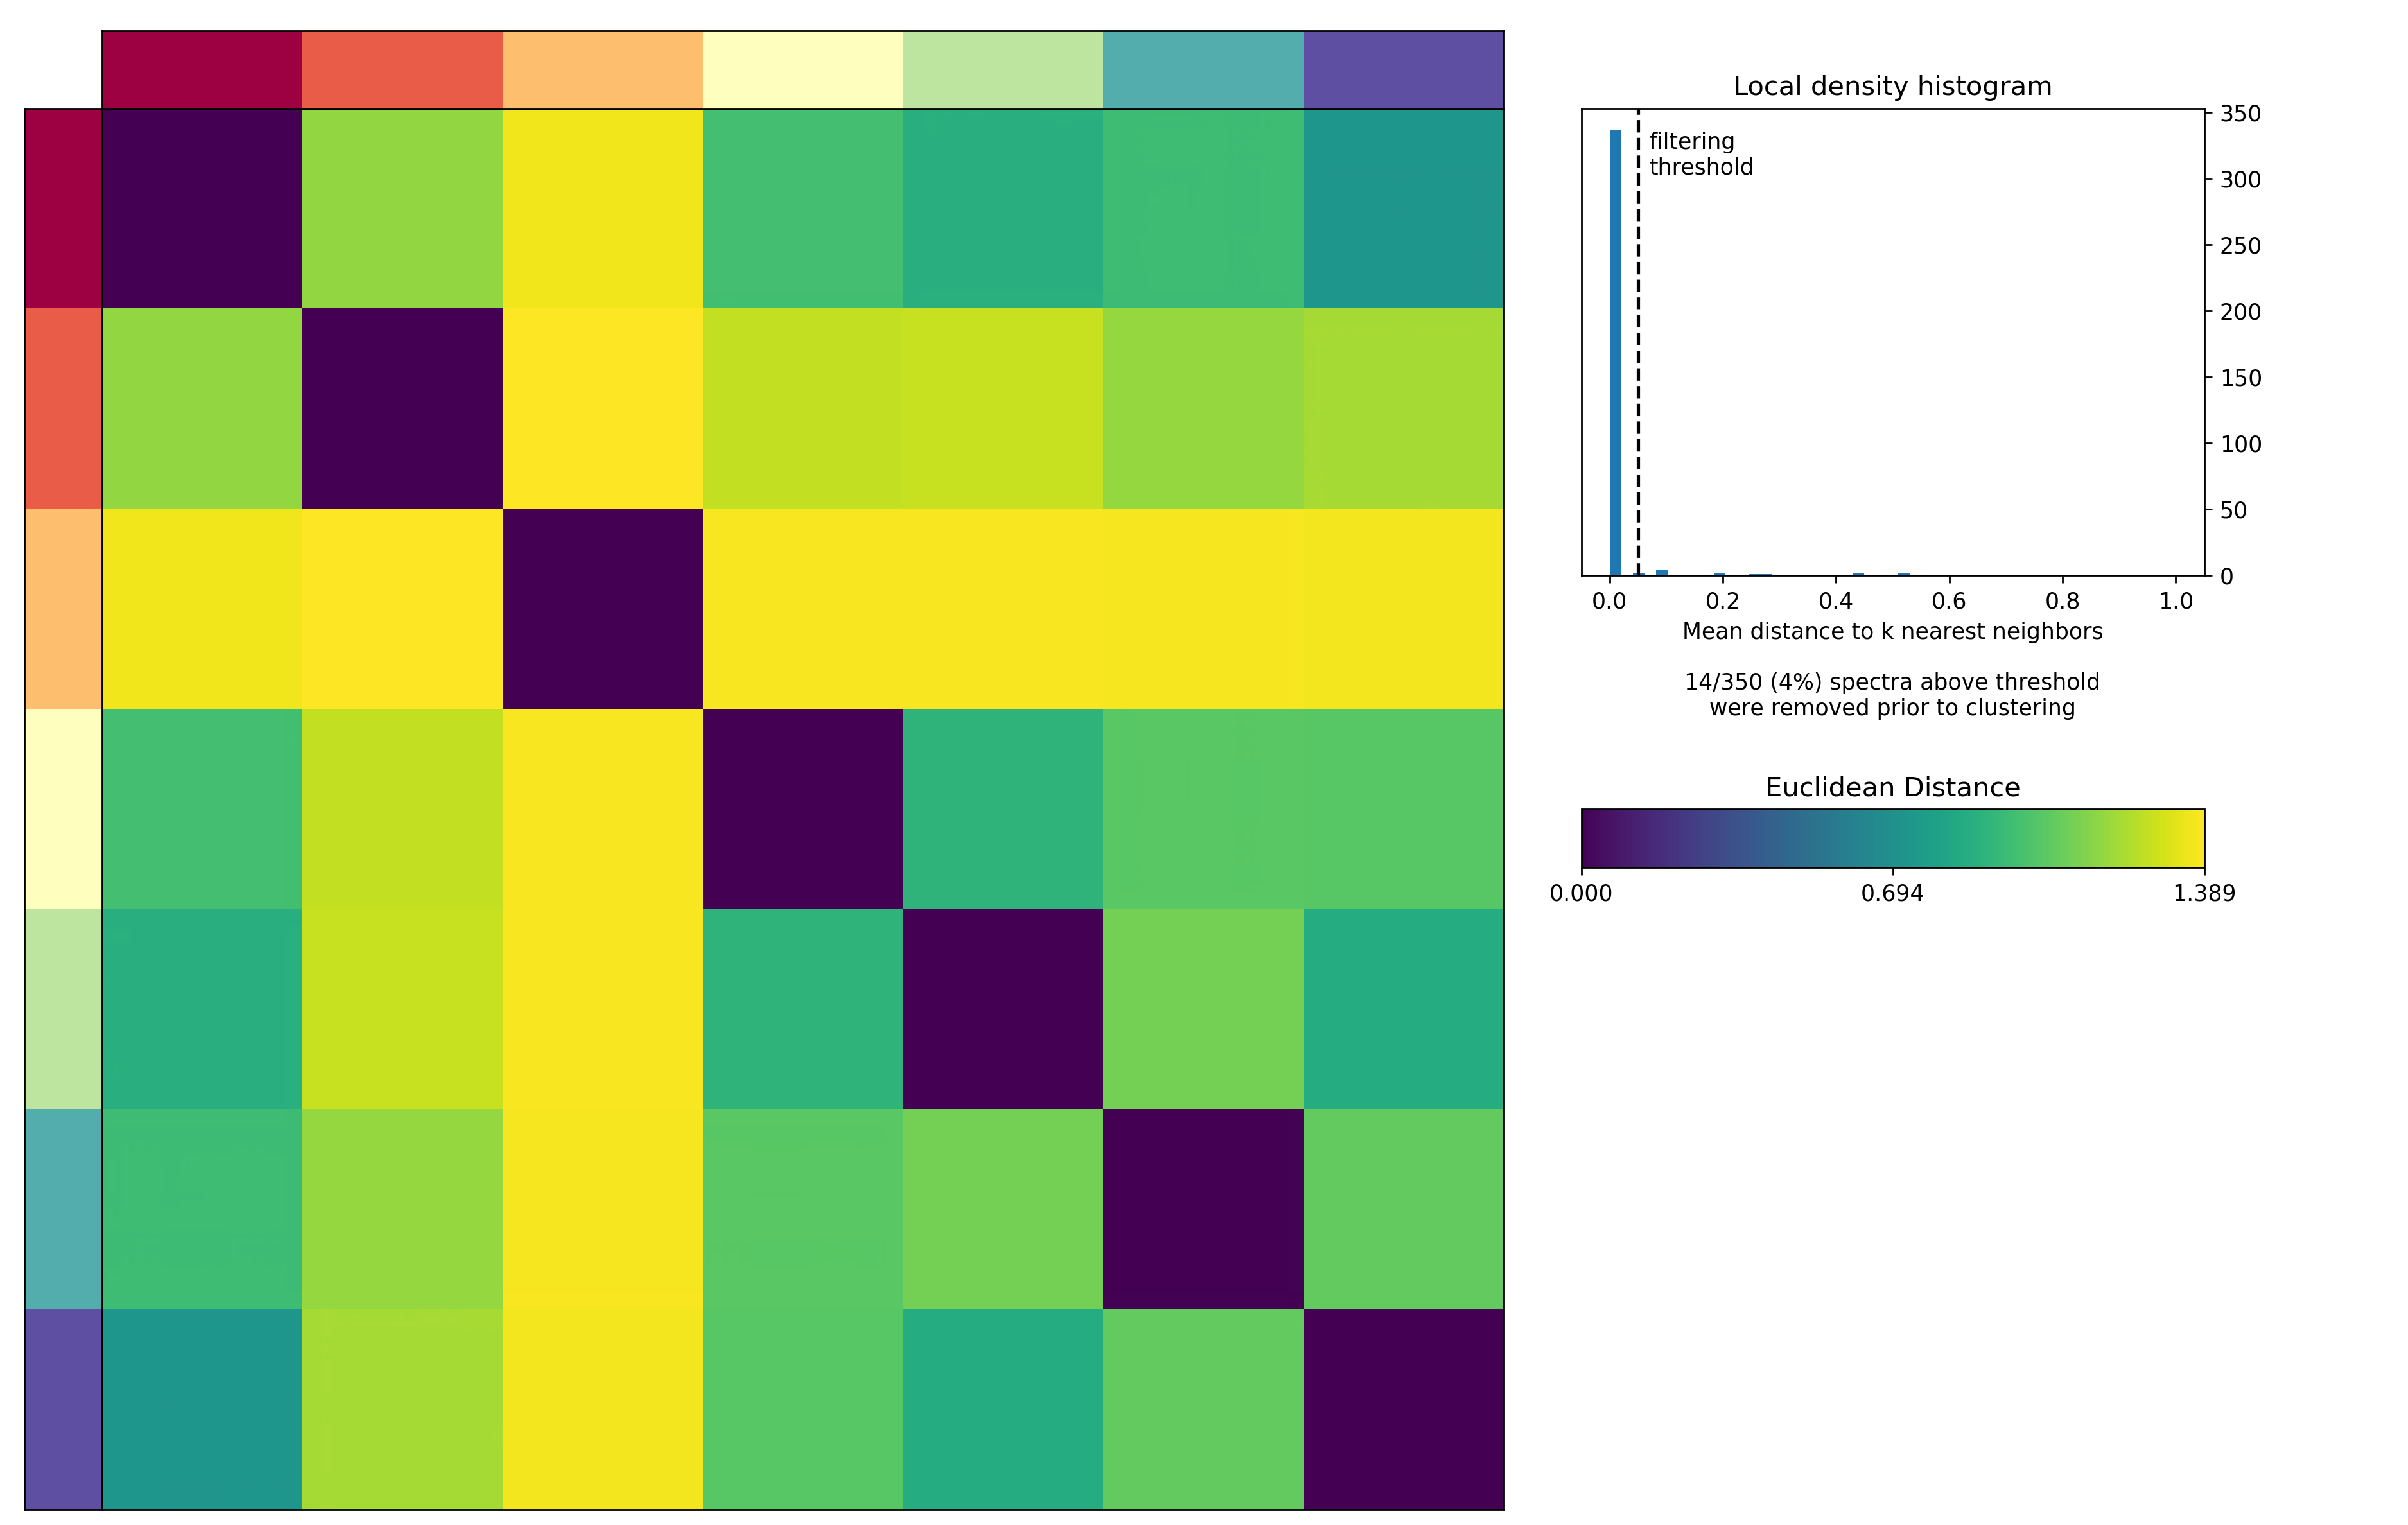

In [33]:
fn = "{o}/{name}/{name}.clustering.k_{K}.dt_{ds}.png".format(o=odir, name=name, K=selected_K, ds=density_threshold_str)
Image(filename = fn,
      width=1000, height=1000)

In [ ]:
adata_T.obs.drop(usage_norm.columns, inplace=True)

In [10]:
usage_fn = "{o}/{name}/{name}.usages.k_{K}.dt_{ds}.consensus.txt".format(o=odir, name=name, K=selected_K, ds=density_threshold_str)
usage = pd.read_csv(usage_fn,sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

Usage_1   Usage_2  Usage_3   Usage_4   Usage_5   Usage_6  \
AAACATACCGGAGA-1  0.785720  0.054248  0.00000  0.000000  0.160031  0.000000   
AAACATACTGTCTT-1  0.175837  0.027773  0.02278  0.000000  0.612226  0.000574   
AAACATACTTCTAC-1  0.310498  0.000000  0.00000  0.279430  0.137579  0.117484   
AAACATTGCTTCGC-1  0.001891  0.039219  0.00000  0.852056  0.000000  0.043377   
AAACATTGGTTCAG-1  0.146486  0.015630  0.00000  0.033535  0.000000  0.037241   

                   Usage_7  
AAACATACCGGAGA-1  0.000000  
AAACATACTGTCTT-1  0.160810  
AAACATACTTCTAC-1  0.155009  
AAACATTGCTTCGC-1  0.063457  
AAACATTGGTTCAG-1  0.767108

In [11]:
scores_fn = "{o}/{name}/{name}.gene_spectra_score.k_{K}.dt_{ds}.txt".format(o=odir, name=name, K=selected_K, ds=density_threshold_str)
scores = pd.read_csv(scores_fn,sep='\t', index_col=0).T
#usage.columns = ['Usage_%s' % i for i in usage.columns]
#usage_norm = usage.div(usage.sum(axis=1), axis=0)
scores.head()

1         2         3         4         5         6  \
LINC00115  0.000018 -0.000052 -0.000059  0.000040  0.000117 -0.000080   
FAM41C     0.000052  0.000059 -0.000024  0.000022  0.000068 -0.000171   
NOC2L     -0.000254  0.000006  0.000034 -0.000023  0.000109 -0.000012   
KLHL17    -0.000072 -0.000041 -0.000047  0.000104 -0.000032 -0.000083   
PLEKHN1    0.000250 -0.000047 -0.000028  0.000030  0.000090 -0.000060   

                  7  
LINC00115 -0.000040  
FAM41C    -0.000028  
NOC2L      0.000100  
KLHL17     0.000052  
PLEKHN1   -0.000201

In [16]:
top_genes = []
ngenes = 40
for gep in scores.columns:
    top_genes.append(list(scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=scores.columns).T
top_genes.head(30)

1         2          3       4        5          6       7
0     S100A4      RRM2       SDPR    GNLY     GZMK   HLA-DRB1   RPS3A
1        LTB      TYMS       PPBP    GZMH    DUSP2       CD74   RPL32
2        VIM     SPC25        PF4    NKG7    CEBPD    HLA-DRA    CCR7
3    S100A10     UBE2C      GNG11    GZMB    DUSP1   HLA-DRB5   RPS13
4    S100A11       TK1      ACRBP  FGFBP2     NCR3   HLA-DQA1   RPL34
5    TNFRSF4  KIAA0101        GP9    CCL5     LYAR   HLA-DPA1    RPS5
6       PLP2     CCNA2      PTCRA    CST7      FOS   HLA-DPB1   RPS14
7      TIMP1     MKI67      CMTM5  FCGR3A    KLRB1   HLA-DQA2   RPL13
8      TRADD     BIRC5     TMEM40    PRF1      JUN   HLA-DQB1   RPL21
9       AQP3     CCNB2     CLEC1B    CTSW    KLRG1      ACTG1    RPS6
10     GSTK1     CENPA       NRGN    GZMA     GZMA      FANK1   RPL31
11     ANXA1    NUSAP1     TREML1  PRSS23     CCL5      CCR10   RPL11
12     FXYD5     STMN1      TUBB1     B2M   NFKBIA       ACTB    RPL7
13      FUT7      HMMR       MYL9   HLA-C    ZFP36       PFN1   RPLP2
14      IL32       PBK      SPARC    CYBA  SLC4A10  LINC00152   RPS27
15     ANXA2     AURKB        CLU   HLA-B   MT-CO3      TIGIT   RPS12
16    S100A6     GTSE1      CLDN5    HOPX   ZBTB16      NINJ2    SELL
17      CD52     CDC20  HIST1H2AC   ASCL2      ID2      HLA-A    RPL9
18     USP10    TUBA1B       SNCA  TYROBP   MT-ND4     TMSB4X   RPS25
19    TAGLN2     HMGB2        CA2   SPON2   MT-CO1    HLA-DMA   RPS23
20      EMP3    PKMYT1    C2orf88  ZNF683     MATK     TMSB10   RPL19
21    LGALS1     TOP2A     ITGA2B    CCL4    CXCR4      COTL1    RPS8
22      KLF6      CDK1      RGS18   FCRL6     CTSW      GAPDH  RPL10A
23      CTSH     CENPF       NFE2   GPR56    CXXC5    ARHGDIB    LDHB
24      CAPG      ASPM      SEPT5    CD8A   MT-CYB       RGS1    LEF1
25      FTH1      CDT1      RAB32    CD63   MT-CO2       CD70    RPS9
26  TNFRSF18      PLK1       SMOX   KLRD1   MT-ND2    PTPRCAP    RPL3
27     CRIP2     MYBL2       MYLK  LGALS1     CST7       IL32  RPL18A
28  SH3BGRL3     CDCA2      ABCC3   HLA-A  ZFP36L2      IL2RA    RPL4
29    CORO1B      SKA3      GFI1B    HCST   MT-ND1       MYL6    AIF1

In [14]:
adata_T.obs = pd.merge(left=adata_T.obs, right=usage_norm, how='left', left_index=True, right_index=True)

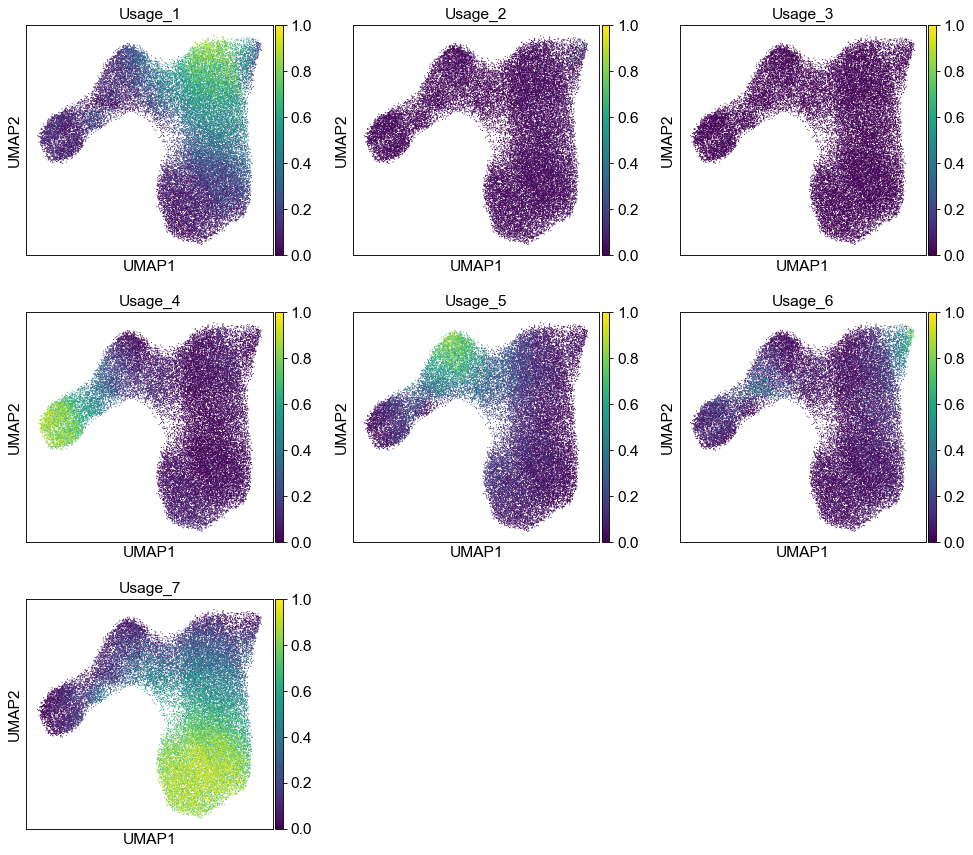

In [15]:
sc.pl.umap(adata_T, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=1)